In [1]:
!pip install --quiet uncertainty-engine

In [2]:
import uncertainty_engine
import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
is_google_colab = False
is_local = not is_google_colab

In [4]:
if is_google_colab:
    from google.colab import userdata

    os.environ["UE_PASSWORD"] = userdata.get("UE_PASSWORD")
    os.environ["UE_USERNAME"] = userdata.get("UE_USERNAME")

In [5]:
if is_local:
    !pip install --quiet python-dotenv
    from dotenv import load_dotenv
    # automatically load .env in current directory
    load_dotenv()

In [6]:
client = uncertainty_engine.Client()

In [7]:
client.authenticate()

In [8]:
PROJECT_NAME = "December Workshop"

In [9]:
from uncertainty_engine.nodes.workflow import Workflow
from io import StringIO
import requests
import pandas as pd

In [10]:
def get_presigned_url(url):
    """
    Get the contents from the presigned url.
    """
    url = url.replace("https://", "http://")
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    return response

def get_results_dataframe(response):
    """
    Get the results dataframe from the workflow response.
    """
    returns = {}
    for key, value in response.outputs["outputs"].items():
        response = get_presigned_url(value)
        df = pd.read_csv(StringIO(response.text))
        returns[key] = df
    return returns

def upload_dataset(client, project_name, filename, filepath):
    """
    Upload a dataset to the specified project.
    """
    try:   
        client.resources.upload(
            project_id=client.projects.get_project_id_by_name(project_name),
            resource_type="dataset",
            name=filename,
            file_path=filepath,
        )
    except Exception as e:
        client.resources.update(
                    project_id=client.projects.get_project_id_by_name(project_name),
                    resource_id=client.resources.get_resource_id_by_name(
                        name=filename,
                        project_id=client.projects.get_project_id_by_name(project_name),
                        resource_type='dataset'
                        ),
                    resource_type="dataset",
                    file_path=filepath,
                )

In [11]:
def run_predict_workflow(client, project_name, workflow_name):
    workflow = client.workflows.load(
        project_id=client.projects.get_project_id_by_name(project_name),
        workflow_id=client.resources.get_resource_id_by_name(
                    name=workflow_name,
                    project_id=client.projects.get_project_id_by_name(project_name),
                    resource_type='workflow'
                    ),
                    client=client
    )
        
    response = client.run_node(workflow)
    results = get_results_dataframe(response)
    mean, std = list(v for v in results.values())
    return mean.to_numpy().squeeze(), std.to_numpy().squeeze()

In [50]:
def predict_thermal(q_par):
    filename = "thermal_prediction"
    filepath = f"{filename}.csv"
    thermal_df = pd.DataFrame({
        "q": q_par,
    })
    thermal_df.to_csv(filepath, index=False)
    upload_dataset(
        client,
        PROJECT_NAME,
        filename,
        filepath
    )
    mean, std = run_predict_workflow(client, PROJECT_NAME, 'Predict_Thermal')
    return mean, std

def predict_neutronics(phi):
    filename = "neutronics_prediction"
    filepath = f"{filename}.csv"
    neutronics_df = pd.DataFrame({
        "phi": phi,
    })
    neutronics_df.to_csv(filepath, index=False)
    upload_dataset(
        client,
        PROJECT_NAME,
        filename,
        filepath
    )
    mean, std = run_predict_workflow(client, PROJECT_NAME, 'Predict_Neutronics')
    return mean, std

def predict_breaking_stress(T, dpa):
    filename = "breaking_prediction"
    filepath = f"{filename}.csv"
    stress_df = pd.DataFrame({
        "T": T,
        "dpa": dpa,
    })
    stress_df.to_csv(filepath, index=False)
    upload_dataset(
        client,
        PROJECT_NAME,
        filename,
        filepath
    )
    mean, std = run_predict_workflow(client, PROJECT_NAME, 'Predict_Breaking')
    return mean, std


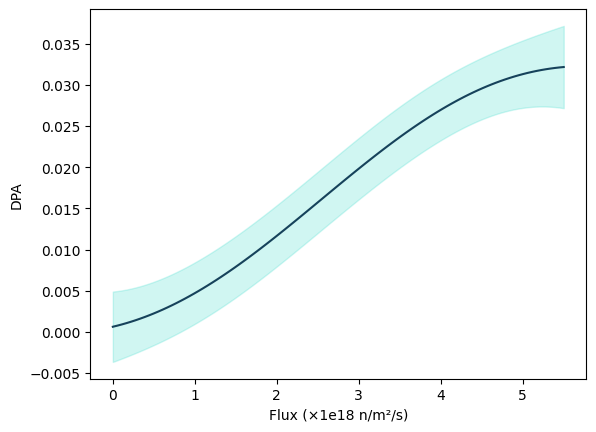

In [59]:
from matplotlib.colors import LinearSegmentedColormap
INDIGO = '#16425B'
KEPPEL = '#16D5C2'
KEY_LIME = '#EBF38B'
BRAND_CMAP = LinearSegmentedColormap.from_list('brand', [INDIGO, KEPPEL, KEY_LIME])

phi = np.linspace(0.0, 5.5, 101)
dpa_mean, dpa_std = predict_neutronics(phi)

plt.plot(phi, dpa_mean, label='Mean DPA Prediction', color=INDIGO)
plt.fill_between(phi,
                  dpa_mean - 1.96 * dpa_std, 
                  dpa_mean + 1.96 * dpa_std, 
                  alpha=0.2, color=KEPPEL)
plt.xlabel('Flux (×1e18 n/m²/s)')
plt.ylabel('DPA')
plt.show()

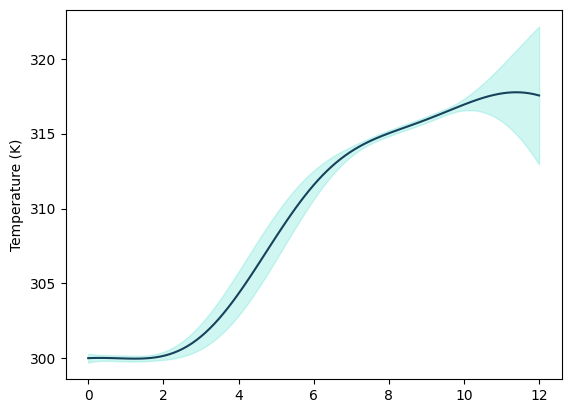

In [48]:
from matplotlib.colors import LinearSegmentedColormap
INDIGO = '#16425B'
KEPPEL = '#16D5C2'
KEY_LIME = '#EBF38B'
BRAND_CMAP = LinearSegmentedColormap.from_list('brand', [INDIGO, KEPPEL, KEY_LIME])

q = np.linspace(0.0, 12.0, 101)
temp_mean, temp_std = predict_thermal(q)

plt.plot(q, temp_mean, label='Mean Temperature Prediction', color=INDIGO)
plt.fill_between(q,
                  temp_mean - 1.96 * temp_std, 
                  temp_mean + 1.96 * temp_std, 
                  alpha=0.2, color=KEPPEL)
plt.ylabel('q (MW/m²)')
plt.ylabel('Temperature (K)')
plt.show()

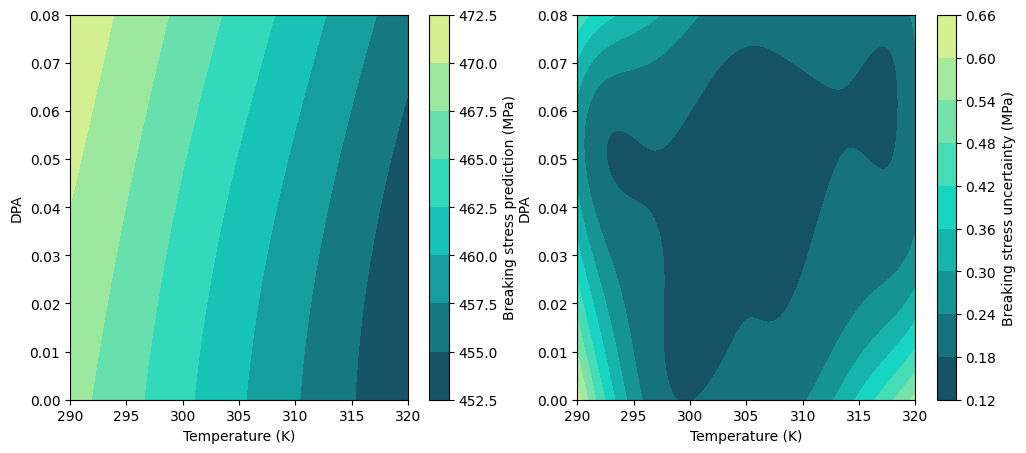

In [60]:
from matplotlib.colors import LinearSegmentedColormap
INDIGO = '#16425B'
KEPPEL = '#16D5C2'
KEY_LIME = '#EBF38B'
BRAND_CMAP = LinearSegmentedColormap.from_list('brand', [INDIGO, KEPPEL, KEY_LIME])

T = np.linspace(290.0, 320.0, 101)
dpa = np.linspace(0.0, 0.08, 101)
T, dpa = np.meshgrid(T, dpa)
bs_mean, bs_std = predict_breaking_stress(T.flatten(), dpa.flatten())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im = axs[0].contourf(
    T,
    dpa,
    bs_mean.reshape(101, 101),
    cmap=BRAND_CMAP
)
plt.colorbar(im, ax=axs[0], label='Breaking stress prediction (MPa)')
axs[0].set_xlabel('Temperature (K)')
axs[0].set_ylabel('DPA')

im = axs[1].contourf(
    T,
    dpa,
    bs_std.reshape(101, 101),
    cmap=BRAND_CMAP
)
plt.colorbar(im, ax=axs[1], label='Breaking stress uncertainty (MPa)')
axs[1].set_xlabel('Temperature (K)')
axs[1].set_ylabel('DPA')
plt.show()


In [61]:
from typing import Dict, Optional, Callable, Union

ArrayLike = Union[float, np.ndarray]

def propagate_uncertainty_to_breaking(
    q_par: ArrayLike,
    neutron_flux: ArrayLike,
    predict_temp: Callable = predict_thermal,
    predict_dpa: Callable = predict_neutronics,
    predict_breaking: Callable = predict_breaking_stress,
    n_mc: int = 500,
    return_samples: bool = False,
    rng: Optional[np.random.Generator] = None,
) -> Dict[str, np.ndarray]:
    """Vectorised uncertainty propagation.

    Returns mean/std with the same (broadcasted) shape as q_par and neutron_flux.
    """
    if rng is None:
        rng = np.random.default_rng()

    q_par_arr = np.asarray(q_par, dtype=float)
    nf_arr = np.asarray(neutron_flux, dtype=float)

    try:
        q_b, nf_b = np.broadcast_arrays(q_par_arr, nf_arr)
    except ValueError as e:
        raise ValueError(
            f"q_par and neutron_flux could not be broadcast together. Got shapes {q_par_arr.shape} and {nf_arr.shape}."
        ) from e

    out_shape = q_b.shape
    n_pts = int(np.prod(out_shape))

    q_1d = q_b.reshape(-1)
    nf_1d = nf_b.reshape(-1)

    mean_T_1d, std_T_1d = predict_temp(q_1d)
    mean_D_1d, std_D_1d = predict_dpa(nf_1d)

    mean_T_1d = np.asarray(mean_T_1d, dtype=float).reshape(-1)
    std_T_1d  = np.asarray(std_T_1d,  dtype=float).reshape(-1)
    mean_D_1d = np.asarray(mean_D_1d, dtype=float).reshape(-1)
    std_D_1d  = np.asarray(std_D_1d,  dtype=float).reshape(-1)

    if not (len(mean_T_1d) == len(std_T_1d) == len(mean_D_1d) == len(std_D_1d) == n_pts):
        raise ValueError(
            "predict_temp/predict_dpa must return 1d arrays matching the flattened input length."
        )

    T_samples = rng.normal(loc=mean_T_1d[:, None], scale=std_T_1d[:, None], size=(n_pts, n_mc))
    D_samples = rng.normal(loc=mean_D_1d[:, None], scale=std_D_1d[:, None], size=(n_pts, n_mc))

    T_flat = T_samples.reshape(-1)
    D_flat = D_samples.reshape(-1)
    
    mu_Y_flat, std_Y_flat = predict_breaking(T_flat, D_flat)

    mu_Y_flat  = np.asarray(mu_Y_flat, dtype=float).reshape(-1)
    std_Y_flat = np.asarray(std_Y_flat, dtype=float).reshape(-1)

    mean_Y = mu_Y_flat.reshape(n_pts, n_mc)
    var_Y  = (std_Y_flat.reshape(n_pts, n_mc)) ** 2

    mean_out_1d = mean_Y.mean(axis=1)
    var_out_1d = var_Y.mean(axis=1) + mean_Y.var(axis=1, ddof=1)
    std_out_1d = np.sqrt(var_out_1d)

    result: Dict[str, np.ndarray] = {
        "mean": mean_out_1d.reshape(out_shape),
        "std":  std_out_1d.reshape(out_shape),
    }

    if return_samples:
        y_samples = rng.normal(loc=mean_Y, scale=np.sqrt(var_Y))
        result["samples"] = y_samples.reshape((*out_shape, n_mc))

    return result


In [62]:
q = np.linspace(0.0, 10.0, 41)
phi = np.linspace(0.0, 5., 40)
q, phi = np.meshgrid(q, phi)
q = q.flatten()
phi = phi.flatten()

res = propagate_uncertainty_to_breaking(
    q,
    phi,
    predict_thermal,
    predict_neutronics,
    predict_breaking_stress,
)


In [63]:
propogated_breaking_mean, propogated_breaking_std = res['mean'], res['std']


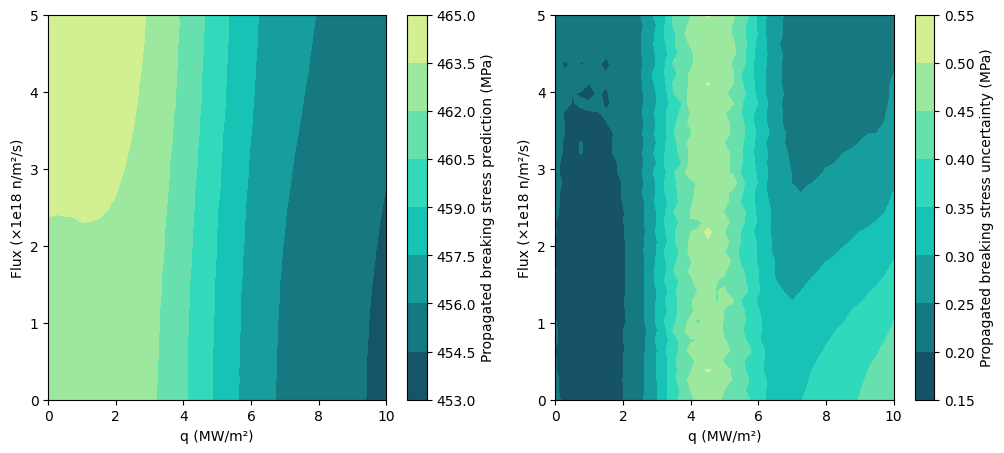

In [64]:
from matplotlib.colors import LinearSegmentedColormap
INDIGO = '#16425B'
KEPPEL = '#16D5C2'
KEY_LIME = '#EBF38B'
BRAND_CMAP = LinearSegmentedColormap.from_list('brand', [INDIGO, KEPPEL, KEY_LIME])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im = axs[0].contourf(
    q.reshape(40, 41),
    phi.reshape(40, 41),
    propogated_breaking_mean.reshape(40, 41),
    cmap=BRAND_CMAP
)
plt.colorbar(im, ax=axs[0], label='Propagated breaking stress prediction (MPa)')
axs[0].set_xlabel('q (MW/m²)')
axs[0].set_ylabel('Flux (×1e18 n/m²/s)')

im = axs[1].contourf(
    q.reshape(40, 41),
    phi.reshape(40, 41),
    propogated_breaking_std.reshape(40, 41),
    cmap=BRAND_CMAP
)
plt.colorbar(im, ax=axs[1], label='Propagated breaking stress uncertainty (MPa)')
axs[1].set_xlabel('q (MW/m²)')
axs[1].set_ylabel('Flux (×1e18 n/m²/s)')
plt.show()


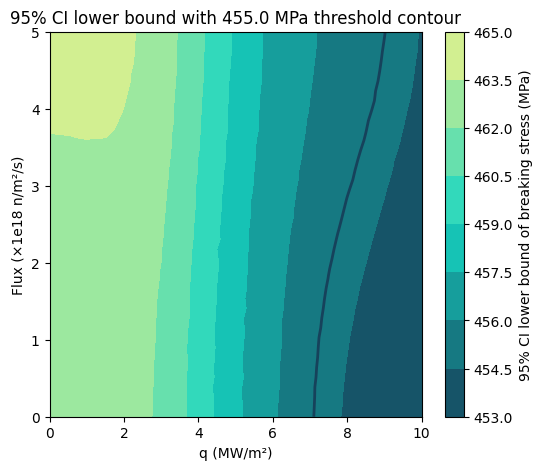

In [68]:
from matplotlib.colors import LinearSegmentedColormap
INDIGO = '#16425B'
KEPPEL = '#16D5C2'
KEY_LIME = '#EBF38B'
BRAND_CMAP = LinearSegmentedColormap.from_list('brand', [INDIGO, KEPPEL, KEY_LIME])

lower_bound = propogated_breaking_mean - 1.96 * propogated_breaking_std
breaking_stress_level = 455.0  # MPa threshold to highlight

fig, ax = plt.subplots(figsize=(6, 5))
cs = ax.contourf(
    q.reshape(40, 41),
    phi.reshape(40, 41),
    lower_bound.reshape(40, 41),
    cmap=BRAND_CMAP
)
plt.colorbar(cs, ax=ax, label='95% CI lower bound of breaking stress (MPa)')
ax.contour(
    q.reshape(40, 41),
    phi.reshape(40, 41),
    lower_bound.reshape(40, 41),
    levels=[breaking_stress_level],
    colors=[INDIGO],
    linewidths=2,
)
ax.set_xlabel('q (MW/m²)')
ax.set_ylabel('Flux (×1e18 n/m²/s)')
ax.set_title(f'95% CI lower bound with {breaking_stress_level} MPa threshold contour')
plt.show()
